# Identify AV tweets with LDA + BOW
Pyro LDA: https://pyro.ai/examples/prodlda.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import time
import json
import random
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

import hashlib
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !ls "drive/MyDrive/Topic Modeling" # Ximin
# !ls "drive/Shareddrives/AV_Twitter_Project/Topic Modeling/data" # Ran

In [ ]:
# set working directory
cwd = "drive/MyDrive/Topic Modeling" # Ximin
# cwd = "drive/Shareddrives/AV_Twitter_Project/Topic Modeling" # Ran

# make exp path
exp_path = os.path.join(cwd, "exp", "lda+bow")
if not os.path.exists(exp_path):
    os.mkdir(exp_path)

## Lemmatize data
Keep PROPN, NOUN, VERB. Compute MD5 hash for every processed tweet

In [ ]:
def remove_tags(df):
    """ remove tweet-processor lib tags """
    # python does not allow $XXX$ symbols
    df = df.str.replace("$", "")
    df = df.str.replace("URL", "")
    df = df.str.replace("HASHTAG", "")
    df = df.str.replace("MENTION", "")
    df = df.str.replace("RESERVED", "")
    df = df.str.replace("EMOJI", "")
    df = df.str.replace("SMILEY", "")
    df = df.str.replace("NUMBER", "")
    return df

def hash_md5(text):
    return hashlib.md5(text.encode()).digest()

def lemmatize(
    doc, stop_words=STOP_WORDS, pos=["PROPN", "NOUN", "VERB"], 
    keywords=[], min_len=3
    ):
    """ 
    args:
        doc: spacy doc object
        pos: allowed part of speech, default=["PROPN", "NOUN", "VERB"]
        keywords: included keywords anyway, default=[]
        min_len: min number of letters in a word, default=3
    """
    tokens = [
        token.lemma_.lower() for token in doc \
        if ((token.pos_ in pos and len(token.lemma_) >= min_len) \
            or token.lemma_.lower() in keywords) \
            and (token.lemma_.lower() not in stop_words)
    ]
    return " ".join(tokens)

def preprocess(
    df, stop_words=STOP_WORDS, pos=["PROPN", "NOUN", "VERB"], 
    keywords=[], min_len=3
    ):
    text = remove_tags(df["tokens"].astype(str))
    text = text.str.replace("[^\w\s]", " ") # strip punctuations

    nlp = spacy.load(
        "en_core_web_sm", 
        enable=["tokenizer", "lemmatizer"],
        disable=["parser", "ner", "ent"], 
    )
    docs = list(nlp.pipe(text.tolist()))
    lemmas = [
        lemmatize(doc, stop_words, pos, keywords, min_len) for doc in docs
    ]

    df = df.assign(lemmas=lemmas)
    df = df.assign(md5=df["lemmas"].apply(hash_md5))
    df = df.assign(num_lemmas=df["lemmas"].str.split().apply(len))
    
    return df

In [ ]:
# load data
data_paths = glob.glob(os.path.join(cwd, "data/opinion_modeling/raw_csv/", "*.csv"))

pprint([os.path.basename(path) for path in data_paths])
print(f"\nnum_events: {len(data_paths)}")

['confused_tesla_incident_in_february.csv',
 'mcity_driverless_shuttle_launches_on_um_north_campus.csv',
 'las_vegas_autonomous_shuttle_crash.csv',
 'introduction_of_tesla_autopilot.csv',
 'world_first_production_car_to_offer_level_3_automation.csv',
 'google_lexus_suv.csv',
 'tesla_model_x_fatality.csv',
 'march_1st_2019_highway_crash_fatality.csv',
 'tesla_model_s_fatal_crash_in_china.csv',
 'uber_self_driving_volvo_crash.csv',
 'university_of_michigan_mcity.csv',
 'first_automated_vehicle_crash_fatality_takes_place.csv']

num_events: 12


In [ ]:
# preprocess
process_config = {
    "debug": False, 
    "pos": ["PROPN", "NOUN", "VERB"], # pos to keep
    "keywords": ["autonomous"],
    "min_len": 3 # min number of letters per word
}
processed_path = os.path.join(cwd, "data/opinion_modeling/lemmas/")
if not os.path.exists(processed_path):
    os.mkdir(processed_path)

print("processing tweets...")

start_time = time.time()
for i, data_path in enumerate(data_paths):
    filename = os.path.basename(data_path)
    df = pd.read_csv(data_path, lineterminator="\n")

    if process_config["debug"]:
        df = df.iloc[:10000]

    df_processed = preprocess(
        df, 
        STOP_WORDS,
        process_config["pos"], 
        process_config["keywords"], 
        process_config["min_len"]
    )
    
    # save processed df
    df_processed = df_processed[["tweet_id", "text", "lemmas", "md5", "num_lemmas"]]
    df_processed.to_csv(os.path.join(processed_path, filename), index=False)
    
    print(
        "{}, time: {:.2f}, data size: {}".format(
        i, time.time() - start_time, df_processed.shape
        )
    )
    if process_config["debug"] and i >= 0:
        break

processing tweets...
0, time: 57.23, data size: (67689, 5)
1, time: 127.34, data size: (85512, 5)
2, time: 163.39, data size: (44651, 5)
3, time: 188.17, data size: (32521, 5)
4, time: 219.98, data size: (43103, 5)
5, time: 256.71, data size: (51748, 5)
6, time: 359.66, data size: (129713, 5)
7, time: 434.52, data size: (93357, 5)
8, time: 462.53, data size: (36941, 5)
9, time: 557.12, data size: (117840, 5)
10, time: 588.29, data size: (42768, 5)
11, time: 650.58, data size: (92817, 5)


## ProdLDA

In [ ]:
!pip install pyro-ppl &> /dev/null

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import spacy
import torchtext
from collections import Counter, OrderedDict
from torchtext.vocab import Vocab
from torchtext.vocab import vocab as build_vocab
from torchtext.data.utils import get_tokenizer

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange

import gc # garbage collector

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


### 1. Data functions
Aggregate all events. Remove duplicate by MD5 hash. Build vocab with torchtext.

In [ ]:
class TwitterData(Dataset):
    def __init__(self, df, pipeline, max_vocab, bow=True):
        super().__init__()
        self.df = df
        self.pipeline = pipeline
        self.max_vocab = max_vocab
        self.bow = bow

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx]
        processed_text = torch.Tensor(self.pipeline(text)).long().view(1, -1)

        if self.bow:
            bow = torch.zeros(self.max_vocab)
            bow[processed_text] = 1
            processed_text = bow

        return processed_text.to(device)

def load_data():
    data_paths = glob.glob(os.path.join(cwd, "data/opinion_modeling/lemmas/", "*.csv"))

    print("loading lemmatized data...")

    # concat all events
    start_time = time.time()
    df = []
    for i, data_path in enumerate(data_paths):
        print(i, os.path.basename(data_path))
        df.append(pd.read_csv(data_path, lineterminator="\n"))
    df = pd.concat(df)
    df["lemmas"] = df["lemmas"].astype(str)

    # drop short text
    min_words = 5 
    df = df.loc[df["num_lemmas"] >= min_words]

    # filter md5
    df = df.drop_duplicates(subset="md5", keep="first")
    df = df.reset_index(drop=True)

    print(f"\ndata size: {df.shape}, time: {(time.time() - start_time):.2f}")
    return df

def build_torchtext_vocab(docs, min_df=1, max_vocab=10000):
    """ 
    args:
        docs: list or df of doc strings
        min_df: min doc frequency, default=1
        max_vocab_size: max vocab to include, default=10000

    returns:
        text_pipeline: tokenizing pipeline for dataset object
        vocab: torchtext vocab object
        ordered_dict: vocab dict and freq
    """
    tokenizer = get_tokenizer("basic_english")
    counter = Counter()
    for line in docs:
        counter.update(tokenizer(line))
    counter = counter.most_common(max_vocab)

    sorted_by_freq_tuples = sorted(counter, key=lambda x: x[1], reverse=True)
    ordered_dict = OrderedDict(sorted_by_freq_tuples)
    vocab = build_vocab(ordered_dict, min_freq=min_df)

    # add <unk> token and default index
    if "<unk>" not in vocab: vocab.insert_token("<unk>", 0)
    vocab.set_default_index(-1)
    vocab.set_default_index(vocab["<unk>"])
    
    # preprocess pipeline
    text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

    # make vocab dict
    df_vocab = pd.DataFrame(
        [[k, v, (ordered_dict[k] if k != "<unk>" else 0)] 
        for k, v in vocab.get_stoi().items()], 
        columns=["word", "index", "freq"]
    ).sort_values(by="word", ascending=True).reset_index(drop=True)
    return text_pipeline, vocab, df_vocab

def train_test_split(
    df, sample_ratio=0.99, train_ratio=0.8, batch_size=128, 
    min_df=3, max_vocab=10000, seed=0
    ):
    """
    args:
        sample_ratio: subsample dataset, default=0.99
        train_ratio: percent of train data, default=0.8
        batch_size: default=128
        max_df: max doc frequency, default=0.95
        min_df: min doc count, default=3,
        max_vocab: most frequent words, default=10000
    """
    np.random.seed(seed)
    
    # shuffle data
    df = df.sample(frac=1, random_state=seed)
    
    # subsample dataset
    num_samples = np.ceil(len(df) * sample_ratio).astype(int)
    df = df.iloc[:num_samples]
    
    # split
    num_train = np.ceil(len(df) * train_ratio).astype(int)
    df_train = df.iloc[:num_train]
    df_test = df.iloc[num_train:]

    print(f"\ntrain size: {df_train.shape}, test_size: {df_test.shape}")
    
    pipeline, vocab, df_vocab = build_torchtext_vocab(
        df_train["lemmas"], min_df, max_vocab
    )
    train_loader = DataLoader(
        TwitterData(df_train["lemmas"], pipeline, len(vocab), bow=True),
        batch_size=batch_size, shuffle=True, drop_last=True
    )
    test_loader = DataLoader(
        TwitterData(df_test["lemmas"], pipeline, len(vocab), bow=True),
        batch_size=batch_size, shuffle=False, drop_last=True
    )

    print("Dictionary size: %d" % len(df_vocab["index"].unique()))
    return train_loader, test_loader, df_vocab

NameError: ignored

### 2. Build models

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        
        # to avoid component collapse
        self.drop = nn.Dropout(dropout) 
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False) 
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False) 

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp() 
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout, seed=0):
        super().__init__()
        torch.manual_seed(seed)
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        """ generative process """ 
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # standard logit normal prior 
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # generate words
            count_param = self.decoder(theta)
            total_count = int(docs.sum(-1).max()) # pyro requirement for multinomial
            pyro.sample(
                "obs",
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        """ inference process """
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        """ topic term matrix: [num_topics, num_vocab] """
        return self.decoder.beta.weight.cpu().detach().T

### 3. Metrics and visualization utils

In [ ]:
""" todo: should convert all metrics to torch, then move tc to metrics functions """
def get_top_words(topic_term, df_vocab, topk=20):
    """ top k words in each topic """
    df_vocab = df_vocab.sort_values(by="index")
    num_topics = len(topic_term)

    top_words = []
    for i in range(num_topics):
        idx = topic_term[i].argsort()[:-topk - 1:-1]
        top_words.append([df_vocab["word"].iloc[i] for i in idx])

    return top_words

def get_topic_coherence(loader, topic_term, df_vocab, topk=20):
    """ mutual info based on topk words 
    args:
        loader: torch dataloader
        topic_term: topic-term torch tensor
        df_vocab:
        topk: topk words to use, default=20
    """

    # find the most frequent word index in each topic
    num_topics = len(topic_term)
    topic_term_index = torch.stack(
        [topic_term[i].argsort(descending=True)[:topk] for i in range(num_topics)]
    ).long()
    
    # print topic term words for debug
    # for i in range(num_topics):
    #     top_words = [df_vocab.loc[df_vocab["index"] == int(j)]["word"].values[0] for j in topic_term_index[i]]
    #     print(top_words)
    
    # get full doc-term matrix
    doc_term = torch.cat([d for d in loader], dim=0)
    num_docs = doc_term.shape[0]
    
    # word occurrance prob
    p_i = doc_term.sum(0) / num_docs
    
    # calculate mutual info
    TC = torch.zeros(num_topics)
    for i in range(topk):
        for j in range(i+1, topk):
            p_ij = torch.sum(
                (doc_term[:, topic_term_index[:, i]] + \
                doc_term[:, topic_term_index[:, j]]) > 0, 
            dim=0) / num_docs

            num = torch.log(p_ij + 1e-10) - \
                torch.log(p_i[topic_term_index[:, i]] + 1e-10) - \
                torch.log(p_i[topic_term_index[:, j]] + 1e-10)
            dnm = -torch.log(p_ij + 1e-10)
            TC += num / dnm
    
    return TC.mean().data.item()

def get_topic_diversity(topic_term):
    """ number of unique words in topics """
    num_topics = len(topic_term)

    word_list = []
    count = 0
    for i in range(num_topics):
        for word in topic_term[i]:
            word_list.append(word)
            count += 1
    word_list = list(set(word_list))
    TD = len(word_list) / count
    return TD

def plot_topic_term(topic_term, df_vocab, topk=20, show=False):
    if show:
        %matplotlib inline
    else:
        %matplotlib notebook
    
    df_vocab = df_vocab.sort_values(by="index")
    num_topics = len(topic_term)
    n_row = np.ceil(num_topics / 5).astype(int)

    fig, ax = plt.subplots(n_row, 5, figsize=(15, 5*n_row), sharex=True)
    ax = ax.flatten()
    for i in range(num_topics):
        idx = topic_term[i].argsort()[:-topk - 1:-1]
        top_words = [df_vocab["word"].iloc[i] for i in idx]
        weights = topic_term[i, idx]

        ax[i].barh(top_words, weights, height=0.7)
        ax[i].set_title(f'Topic {i +1}', fontdict={'fontsize': 12})
        ax[i].invert_yaxis()
        ax[i].tick_params(axis='both', which='major', labelsize=12)
        for j in 'top right left'.split():
            ax[i].spines[j].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)

    if show:
        plt.show()

    return fig

### 4. Training functions

In [ ]:
def run_epoch(model, loader, train=True, debug=False):
    """ pass data through model 
    args:
        model: 
        loader: train or test dataloader
        train: train mode, default=True
        debug: default=False
    """
    stats = []
    for i, data_batch in enumerate(loader):
        if train:
            loss = model.step(data_batch)
        else:
            loss = model.evaluate_loss(data_batch)

        stats.append({"elbo": loss / len(data_batch)})

        if debug:
            break

    stats = pd.DataFrame(stats).mean(0).to_dict()
    stats.update({"train": "train" if train else "test"})
    return stats

def main(config):
    torch.manual_seed(config["seed"])
    pyro.set_rng_seed(config["seed"])
    pyro.clear_param_store()

    train_loader, test_loader, df_vocab = train_test_split(
        df, 
        config["sample_ratio"],
        config["train_ratio"],
        config["batch_size"],
        config["min_df"],
        config["max_vocab"],
        config["seed"],
    )
    gc.collect() # collect cache

    prodLDA = ProdLDA(
        vocab_size=len(df_vocab["index"].unique()),
        num_topics=config["num_topics"],
        hidden=config["hidden_dim"],
        dropout=config["dropout"],
        seed=config["seed"]
    )
    prodLDA.to(device)
    print(f"using device: {device}\n")

    optimizer = pyro.optim.Adam(
        {
            "lr": config["lr"],
            "betas": config["betas"]
        }
    )
    svi = SVI(
        prodLDA.model, 
        prodLDA.guide, 
        optimizer, 
        loss=TraceMeanField_ELBO()
    )
    
    # train
    start_time = time.time()
    bar = trange(config["epochs"])
    history = []
    for e in bar: 
        train_stats = run_epoch(svi, train_loader, train=True, debug=config["debug"])
        test_stats = run_epoch(svi, test_loader, train=False, debug=config["debug"])

        # compute topic diversity
        topic_term = prodLDA.beta().data.numpy()
        td = get_topic_diversity(get_top_words(topic_term, df_vocab))
        train_stats.update({"td": td, "epoch": e, "time": time.time() - start_time})
        test_stats.update({"td": td, "epoch": e, "time": time.time() - start_time})
        
        # collect stats
        history.append(train_stats)
        history.append(test_stats)
        
        bar.set_postfix(
            elbo='{:.2f}'.format(train_stats["elbo"]), 
            time="{:.2f}".format(np.round(time.time() - start_time, 2))
        )
        
        if config["debug"] and e > 0:
            break
    
    print(f"\ntrain time: {(time.time() - start_time):.2f}")

    df_history = pd.DataFrame(history)
    
    if config["save"]:
        # make save path
        save_path = os.path.join(
            exp_path,
            "num_topics_{}_hidden_dim_{}_sample_ratio_{}"
            "_min_df_{}_max_vocab_{}_batch_size_{}_lr_{}_seed_{}".format(
                config["num_topics"],
                config["hidden_dim"],
                config["sample_ratio"],
                config["min_df"],
                config["max_vocab"],
                config["batch_size"],
                config["lr"],
                config["seed"]
            )
        )
        if not os.path.exists(exp_path):
            os.mkdir(exp_path)
        if not os.path.exists(save_path):
            os.mkdir(save_path)

        # save config
        with open(os.path.join(save_path, "args.json"), "w") as f:
            json.dump(config, f)
        
        # save history
        df_history.to_csv(os.path.join(save_path, "history.csv"), index=False)

        # save vocab
        df_vocab.to_csv(os.path.join(save_path, "vocab.csv"), index=False)

        # save model
        torch.save(prodLDA.state_dict(), os.path.join(save_path, "model.pth"))
        
        # save topic-term fig
        topk = 20
        topic_term = prodLDA.beta().data.numpy()
        fig = plot_topic_term(topic_term, df_vocab, topk, show=False)
        fig.savefig(os.path.join(save_path, "topic_term.png"), dpi=200)
    
    print("results saved")
    return prodLDA, df_vocab, df_history

### 5. Manual training

In [ ]:
df = load_data()

loading lemmatized data...
0 confused_tesla_incident_in_february.csv
1 mcity_driverless_shuttle_launches_on_um_north_campus.csv
2 las_vegas_autonomous_shuttle_crash.csv
3 introduction_of_tesla_autopilot.csv
4 world_first_production_car_to_offer_level_3_automation.csv
5 google_lexus_suv.csv
6 tesla_model_x_fatality.csv
7 march_1st_2019_highway_crash_fatality.csv
8 tesla_model_s_fatal_crash_in_china.csv
9 uber_self_driving_volvo_crash.csv
10 university_of_michigan_mcity.csv
11 first_automated_vehicle_crash_fatality_takes_place.csv

data size: (323488, 5), time: 4.21


In [ ]:
config = {
    "seed": 1,
    # data config
    "sample_ratio": 0.6, # sub sample dataset 
    "train_ratio": 0.8, 
    "batch_size": 128,
    "min_df": 10, # min doc count
    "max_vocab": 10000, # most freq words
    # model_config
    "num_topics": 10,
    "hidden_dim": 100,
    "dropout": 0.2,
    # train config
    "lr": 1e-3,
    "betas": (0.9, 0.99), # Adam optimizer momentum
    "epochs": 15,
    "debug": False,
    "save": True,
}

model, df_vocab, df_history = main(config)


train size: (155275, 5), test_size: (38818, 5)
Dictionary size: 10001
using device: cuda:0



100%|██████████| 15/15 [13:20<00:00, 53.36s/it, elbo=60.28, time=800.39]


train time: 800.40


<IPython.core.display.Javascript object>

results saved


<IPython.core.display.Javascript object>

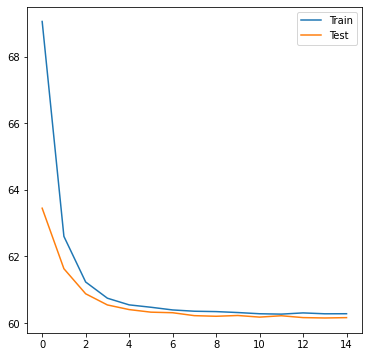

In [ ]:
# plot learning curve
%matplotlib inline

df_train_history = df_history.loc[df_history["train"] == "train"]
df_test_history = df_history.loc[df_history["train"] == "test"]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(df_train_history["epoch"], df_train_history["elbo"], label="Train")
ax.plot(df_test_history["epoch"], df_test_history["elbo"], label="Test")
ax.legend()
plt.show()

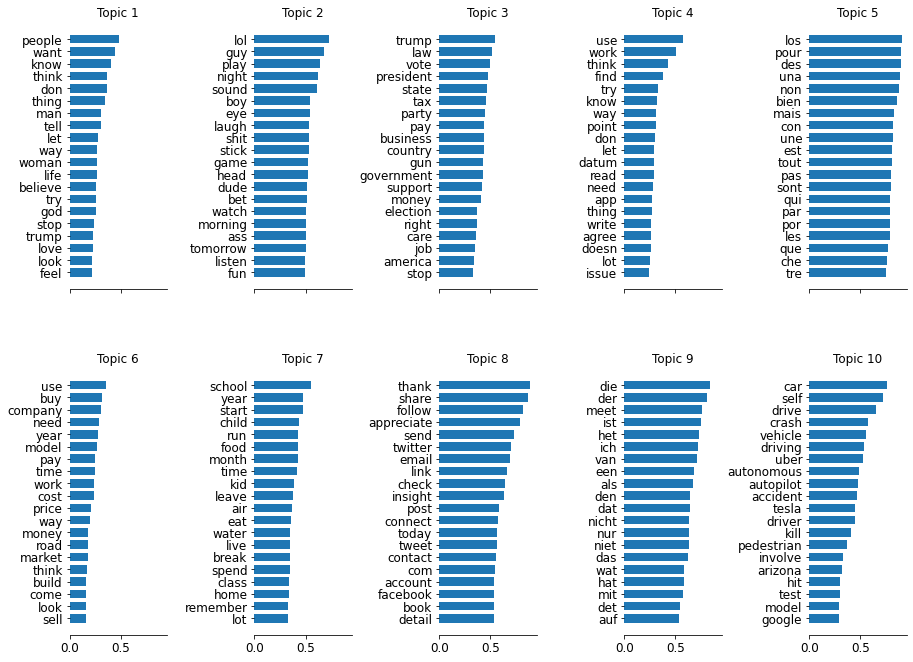

In [ ]:
# plot topic term
topic_term = model.beta().numpy()
fig = plot_topic_term(topic_term, df_vocab, topk=20, show=True)

### 6. Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
def grid_search(param_grid, debug=False):
    print("grid search...")

    for i, params in enumerate(param_grid):
        print("\n", i, params)

        config = {
            "seed": params["seed"],
            # data config
            "sample_ratio":params["sample_ratio"], # sub sample dataset 
            "train_ratio": 0.8, 
            "batch_size": params["batch_size"],
            "min_df": params["min_df"], # min doc count
            "max_vocab": params["max_vocab"], # most freq words
            # model_config
            "num_topics": params["num_topics"],
            "hidden_dim": params["hidden_dim"],
            "dropout": 0.2,
            # train config
            "lr": params["lr"],
            "betas": (0.9, 0.99), # Adam optimizer momentum
            "epochs": params["epochs"],
            "debug": debug,
            "save": True,
        }

        main(config)

        if debug and i > 0: 
            break

In [ ]:
param_grid = ParameterGrid(
    {
        "seed": [1, 2], #[0, 1, 2],
        "sample_ratio": [0.6],
        "min_df": [10], # min doc count
        "max_vocab": [10000], # most freq words
        "num_topics": [20], #[5, 7, 10, 15, 20],
        "hidden_dim": [100],
        "lr": [1e-3],
        "batch_size": [128],
        "epochs": [20]
    }
)

grid_search(param_grid, debug=False)

grid search...

 0 {'batch_size': 128, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.001, 'max_vocab': 10000, 'min_df': 10, 'num_topics': 20, 'sample_ratio': 0.6, 'seed': 1}

train size: (155275, 5), test_size: (38818, 5)
Dictionary size: 10001
using device: cpu



100%|██████████| 20/20 [1:19:23<00:00, 238.15s/it, elbo=60.25, time=4763.10]



train time: 4763.11


<IPython.core.display.Javascript object>

results saved

 1 {'batch_size': 128, 'epochs': 20, 'hidden_dim': 100, 'lr': 0.001, 'max_vocab': 10000, 'min_df': 10, 'num_topics': 20, 'sample_ratio': 0.6, 'seed': 2}

train size: (155275, 5), test_size: (38818, 5)
Dictionary size: 10001
using device: cpu



100%|██████████| 20/20 [1:25:49<00:00, 257.46s/it, elbo=60.21, time=5149.20]


train time: 5149.21


<IPython.core.display.Javascript object>

results saved


## Model selection
Compare models based on metrics.

In [ ]:
def build_vocab_from_df(df_vocab):  
    df_vocab = df_vocab.sort_values(by="index")
    
    # replace nan, this is a bug from preprocessing above
    num_nan = sum(df_vocab["word"].isnull())
    df_vocab["word"].loc[df_vocab["word"].isnull()] = [f"nan_{i}" for i in range(num_nan)]

    tokens = df_vocab["word"].tolist()
    
    # build torchtext vocab
    from torchtext._torchtext import Vocab as VocabPybind
    vocab = VocabPybind(tokens, None)
    vocab = Vocab(vocab)
    
    # add <unk> token and default index
    if "<unk>" not in vocab: vocab.insert_token("<unk>", 0)
    vocab.set_default_index(-1)
    vocab.set_default_index(vocab["<unk>"])

    # preprocess pipeline
    tokenizer = get_tokenizer("basic_english")
    text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
    return text_pipeline, vocab

def load_models(path):
    """ load models and build vocab """
    # load args
    with open(os.path.join(path, "args.json"), "rb") as f:
        config = json.load(f)
    
    # load and build vocab 
    df_vocab = pd.read_csv(os.path.join(path, "vocab.csv"))
    pipeline, vocab = build_vocab_from_df(df_vocab)

    # load state dict
    state_dict = torch.load(os.path.join(path, "model.pth"), map_location=device)

    prodLDA = ProdLDA(
        vocab_size=len(df_vocab["index"].unique()),
        num_topics=config["num_topics"],
        hidden=config["hidden_dim"],
        dropout=config["dropout"],
        seed=config["seed"]
    )
    prodLDA.load_state_dict(state_dict)
    prodLDA.to(device)
    return prodLDA, pipeline, vocab, df_vocab, config

def test_model(path, df_test, batch_size=528, seed=0):
    np.random.seed(seed)

    # load model
    model, pipeline, vocab, df_vocab, config = load_models(path)
    optimizer = pyro.optim.Adam({"lr":1e-3})
    svi = SVI(
        model.model, 
        model.guide, 
        optimizer, 
        loss=TraceMeanField_ELBO()
    )

    # build test dataset
    df_test = df_test.sample(frac=1, random_state=seed)

    test_loader = DataLoader(
        TwitterData(df_test["lemmas"], pipeline, len(vocab), bow=True),
        batch_size=batch_size, shuffle=False, drop_last=False
    )

    # get test stats
    test_stats = run_epoch(svi, test_loader, train=False, debug=True)
    
    # get topic coherence and diversity
    topic_term = model.beta().data
    tc = get_topic_coherence(test_loader, topic_term, df_vocab, topk=35)
    td = get_topic_diversity(get_top_words(topic_term.numpy(), df_vocab))
    
    test_stats.update({"tc": tc, "td": td})
    test_stats.update(config)

    return test_stats

In [ ]:
# sample test data
seed = 0
num_test = 100000
df_test = df.sample(frac=1., random_state=seed).iloc[-num_test:]

In [ ]:
# load models
exp_path = os.path.join(cwd, "exp/lda+bow")
result_paths = glob.glob(os.path.join(exp_path, "*/"))
result_paths = [p for p in result_paths if "deprecate" not in p]

start_time = time.time()
test_stats = []
for i, path in enumerate(result_paths):
    print(i, os.path.basename(os.path.dirname(path)))

    stats = test_model(path, df_test)
    test_stats.append(stats)

print(f"time: {(time.time() - start_time):.2f}")

gc.collect() # clear cache
df_stats = pd.DataFrame(test_stats)

# save stats
df_stats.to_csv(os.path.join(exp_path, "model_comparison.csv"), index=False)

0 num_topics_5_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_0
1 num_topics_5_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_1
2 num_topics_5_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_2
3 num_topics_7_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_0
4 num_topics_7_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_1
5 num_topics_7_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_2
6 num_topics_10_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_0
7 num_topics_10_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_1
8 num_topics_10_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_2
9 num_topics_15_hidden_dim_100_sample_ratio_0.6_min_df_10_max

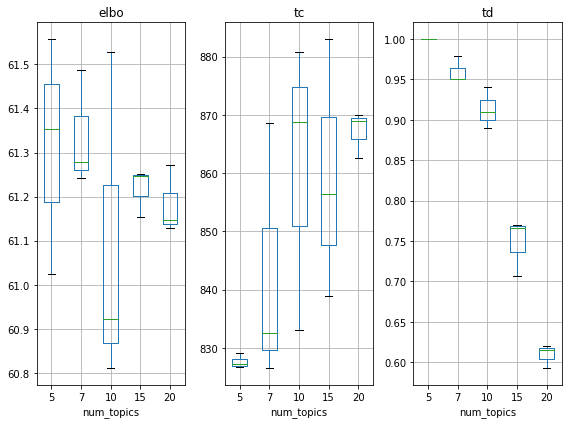

In [ ]:
# plot stats
fig, ax = plt.subplots(1, 3, figsize=(8, 6))
df_stats.boxplot(column="elbo", by="num_topics", ax=ax[0])
df_stats.boxplot(column="tc", by="num_topics", ax=ax[1])
df_stats.boxplot(column="td", by="num_topics", ax=ax[2])
plt.suptitle("")
plt.tight_layout()
plt.show()

## Inference
Infer doc-topic distributions for all tweets. Save separately for each event.

In [ ]:
def inference(model_path, df, batch_size=256):
    model, pipeline, vocab, df_vocab, config = load_models(model_path)
    
    df["lemmas"] = df["lemmas"].astype(str)
    test_loader = DataLoader(
        TwitterData(df["lemmas"], pipeline, len(vocab), bow=True),
        batch_size=batch_size, shuffle=False, drop_last=False
    )
    
    mu, std = [], []
    for i, data_batch in enumerate(test_loader):
        with torch.no_grad():
            mu_, std_ = model.encoder(data_batch)
            mu.append(mu_)
            std.append(std_)
    mu = torch.cat(mu, dim=0)
    std = torch.cat(std, dim=0)
    prob = torch.softmax(mu, dim=1)
    
    topic_term = model.beta().numpy()
    top_words = get_top_words(topic_term, df_vocab, topk=5)
    cols = ["_".join(t) for t in top_words]
    
    # pack inference results
    df_mu = pd.DataFrame(mu.numpy(), columns=["mu_" + col for col in cols])
    df_std = pd.DataFrame(std.numpy(), columns=["std_" + col for col in cols])
    df_prob = pd.DataFrame(prob.numpy(), columns=["prob_" + col for col in cols])
    df_id = df[["tweet_id", "text"]].astype(str)
    df_inf = pd.concat([df_id, df_prob, df_mu, df_std], axis=1)
    return df_inf

In [ ]:
debug = False

data_paths = glob.glob(os.path.join(cwd, "data/opinion_modeling/lemmas", "*.csv"))
exp_path = os.path.join(cwd, "exp/lda+bow")
model_path = os.path.join(
    exp_path, 
    "num_topics_10_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_0"
)
save_path = os.path.join(cwd, "data/opinion_modeling", "lda_bow_inference")
if not os.path.exists(save_path):
    os.mkdir(save_path)

for i, data_path in enumerate(data_paths):
    filename = os.path.basename(data_path)
    print(i, filename)

    df_event = pd.read_csv(data_path, lineterminator="\n")
    if debug:
        df_event = df_event.iloc[:10000]

    df_inference = inference(model_path, df_event, batch_size=256)
    df_inference.to_csv(os.path.join(save_path, filename), index=False)

    if debug:
        break

0 confused_tesla_incident_in_february.csv
1 mcity_driverless_shuttle_launches_on_um_north_campus.csv
2 las_vegas_autonomous_shuttle_crash.csv
3 introduction_of_tesla_autopilot.csv
4 world_first_production_car_to_offer_level_3_automation.csv
5 google_lexus_suv.csv
6 tesla_model_x_fatality.csv
7 march_1st_2019_highway_crash_fatality.csv
8 tesla_model_s_fatal_crash_in_china.csv
9 uber_self_driving_volvo_crash.csv
10 university_of_michigan_mcity.csv
11 first_automated_vehicle_crash_fatality_takes_place.csv


## AV classification
Linear binary classification

In [ ]:
# make data for classification
debug = True

exp_path = os.path.join(cwd, "exp/lda+bow")
model_path = os.path.join(
    exp_path, 
    "num_topics_10_hidden_dim_100_sample_ratio_0.6_min_df_10_max_vocab_10000_batch_size_128_lr_0.001_seed_0"
)
save_path = os.path.join(cwd, "data/opinion_modeling/av_classification")
if not os.path.exists(save_path):
    os.mkdir(save_path)

# loag data
df = load_data()
df = df.sample(frac=1, random_state=0).reset_index(drop=True)
if debug:
    df = df.iloc[:30000]

df_inference = inference(model_path, df)
df_inference = df_inference[["tweet_id", "text"] + [col for col in df_inference.columns if "prob" in col]]
df_inference.to_csv(os.path.join(save_path, "doc_topic.csv"), index=False)
print("\ninference done")

loading lemmatized data...
0 confused_tesla_incident_in_february.csv
1 mcity_driverless_shuttle_launches_on_um_north_campus.csv
2 las_vegas_autonomous_shuttle_crash.csv
3 introduction_of_tesla_autopilot.csv
4 world_first_production_car_to_offer_level_3_automation.csv
5 google_lexus_suv.csv
6 tesla_model_x_fatality.csv
7 march_1st_2019_highway_crash_fatality.csv
8 tesla_model_s_fatal_crash_in_china.csv
9 uber_self_driving_volvo_crash.csv
10 university_of_michigan_mcity.csv
11 first_automated_vehicle_crash_fatality_takes_place.csv

data size: (323488, 5), time: 4.02

inference done


In [ ]:
df_doc_topic = df_inference[[col for col in df_inference.columns if "prob" in col]]

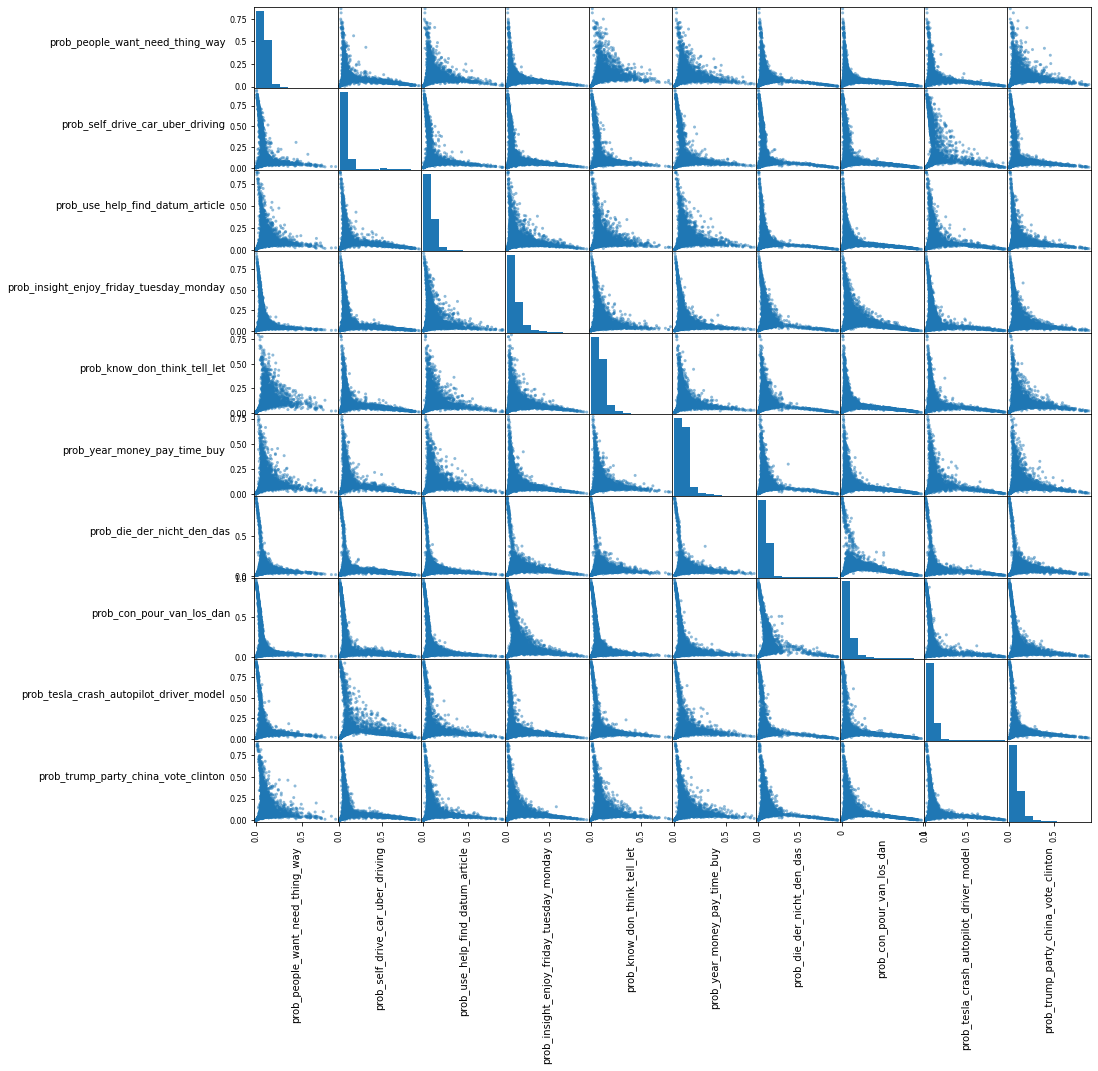

In [ ]:
# scatter plot matrix of topic probs
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
axes = pd.plotting.scatter_matrix(df_doc_topic, ax=ax)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
plt.show()

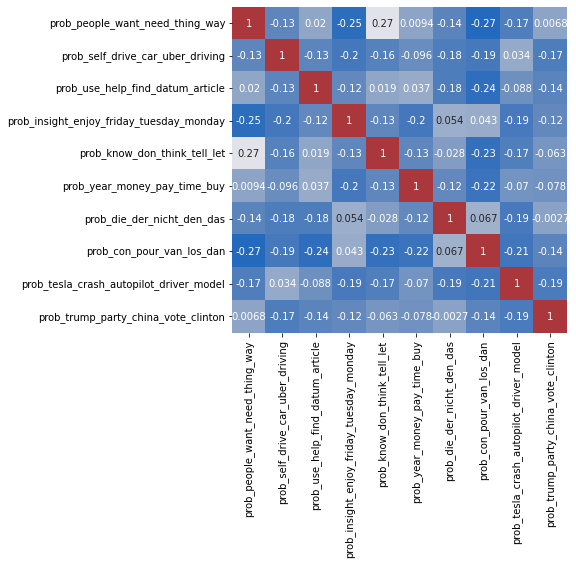

In [ ]:
# plot correlation of topic probs
corr = df_doc_topic.corr()
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap="vlag", cbar=False, ax=ax)
plt.show()